## Avaliação em holdouts - Amazon Books

Interactions in the 'Amazon Books' dataset are well distributed.
Several users are present during the whole considered period (1st 4 months of 2014):
<!-- * 37067 users of 190248 (19.484%) occurr in 80.0% or more months. -->
* 29316 users of 63848 (45.915%) occurr in 80.0% or more months.
___ 

No experiments with fixed buckets are made.

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Amazon Books
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [4]:
# importa dataset 'lastfm playlists'
data = pd.read_csv('output/amazonbooks_dump/sampled_amazon_books.csv')
dataset_name = 'Amazon_Books'
user_col = 'user_id'
item_col = 'item_id'

In [5]:
data.shape

(1056276, 4)

In [6]:
data.head()

user_id         item_id   timestamp        date
0  000100039X  A1GE8MHKYO3RDD  1388707200  2014-01-01
1  000100039X  A21X7PJN5UNVQ3  1389139200  2014-01-01
2  000100039X   AXU973Y796R6T  1389139200  2014-01-01
3  000100039X  A13TVGX3P7ZCTE  1389312000  2014-01-01
4  000100039X  A3UY8MG7G9BZ0D  1389571200  2014-01-01

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056276 entries, 0 to 1056275
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1056276 non-null  object
 1   item_id    1056276 non-null  object
 2   timestamp  1056276 non-null  int64 
 3   date       1056276 non-null  object
dtypes: int64(1), object(3)
memory usage: 32.2+ MB


### Convert timestamp

In [8]:
%%time 
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data.sort_values(by='timestamp', inplace=True)

In [9]:
data.head()

user_id         item_id   timestamp       date
629940  1118821076   A5G0WNEB7OVDG  1388534400 2014-01-01
599730  0989163407  A2S07QXVJQK7LH  1388534400 2014-01-01
898149  1505244277   A6Y92DB2QT9BH  1388534400 2014-01-01
954022  1614270570   AFOK2P3RXM5XY  1388534400 2014-01-01
953985  1613890060   AFFCK9296ILWN  1388534400 2014-01-01

CPU times: user 438 ms, sys: 26.9 ms, total: 465 ms
Wall time: 462 ms


Text(0.5, 1.0, 'interactions per month')

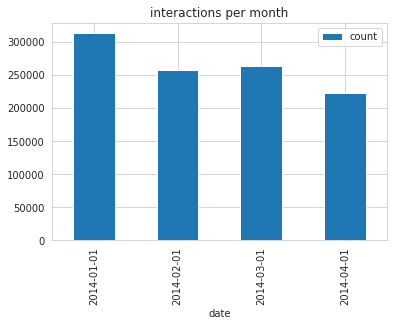

In [10]:
%%time
# 799ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month')

___
## Get intervals and Frequent users (threshold = 0.8)

time intervals

In [11]:
user_presence_df = pd.read_csv('output/amazonbooks_dump/user_presence_df.csv')
user_month_interactions = pd.read_csv('output/amazonbooks_dump/user_month_interactions.csv')

In [12]:
frequent_users_month = joblib.load('output/amazonbooks_dump/frequent_users_month.joblib')

___
## Experiments using months

In [13]:
%%time
# 36min 48s
buckets, holdouts = getBucketsHoldouts(
    data=data,
    user_col=user_col,
    item_col=item_col,
    frequent_users=frequent_users_month,
    interval_type='M',
    intervals=None, 
    cold_start_buckets=1)

Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between bucket 1 and all holdouts.
25
common interactions between bucket 2 and all holdouts.
29317
common interactions between bucket 3 and all holdouts.
29324
common interactions between bucket 4 and all holdouts.
29320
Converting to ImplicitData. . .
Done!
CPU times: user 36min 47s, sys: 583 ms, total: 36min 48s
Wall time: 36min 48s


In [14]:
joblib.dump(buckets, 'output/amazonbooks_dump/buckets.joblib')
joblib.dump(holdouts, 'output/amazonbooks_dump/holdouts.joblib')

['output/amazonbooks_dump/holdouts.joblib']

### ISGD

Hyperparameters

In [15]:
# define hyperparameters (SAME AS LASTFM)
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [16]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
%%time
# 16 min
# criamos instancia de EvaluateHoldouts para treinar modelos e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

bucket 0


/home/kpereira/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:84: RuntimeWarning: overflow encountered in multiply
  delta = self.learn_rate * (err * p_u - self.item_regularization * q_i)
/home/kpereira/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:84: RuntimeWarning: invalid value encountered in subtract
  delta = self.learn_rate * (err * p_u - self.item_regularization * q_i)


bucket 1


In [ ]:
%%time
eval.EvaluateHoldouts(N_recommendations=20, exclude_known_items=True, default_user='none')

In [ ]:
rm = eval.results_matrix
df = pd.DataFrame(rm.T)
df.to_csv('output/amazonbooks_dump/amazon_books month_bucket ISGD results.csv', index=False)
# df = pd.read_csv('output/palco2010/palco_2010 month_bucket ISGD results.csv')

In [ ]:
recall_heatmap(df,
    title='Recall@20 for ISGD models across Holdouts - Amazon Books',
    filepath='images/heatmaps/amazonbooks_dump/amazon_books month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [ ]:
arecall = avg_recall(df)
arecall

In [ ]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

In [ ]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

___
## Experiments using quarter

No sense
0 users of 7580 (0.0%) occurr in 80.0% or more quarters.


___
## Experiments using semester


In [20]:
buckets, holdouts = getBucketsHoldouts(data=data, user_col=user_col, item_col=item_col, frequent_users=frequent_users_semestre, interval_type='QS', intervals=semestres, cold_start_buckets=1)


### ISGD

In [21]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [22]:
# criamos instancia de EvaluateHoldouts para treinar modelos e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)
# 17 min

bucket 0
bucket 1


In [23]:
eval.EvaluateHoldouts(N_recommendations=20, exclude_known_items=True, default_user='none')

In [24]:
rm = eval.results_matrix
df = pd.DataFrame(rm.T)
df.to_csv('output/palco2010/palco_2010 semester_bucket ISGD results.csv', index=False)
# df = pd.read_csv('output/palco2010/palco_2010 month_bucket ISGD results.csv')

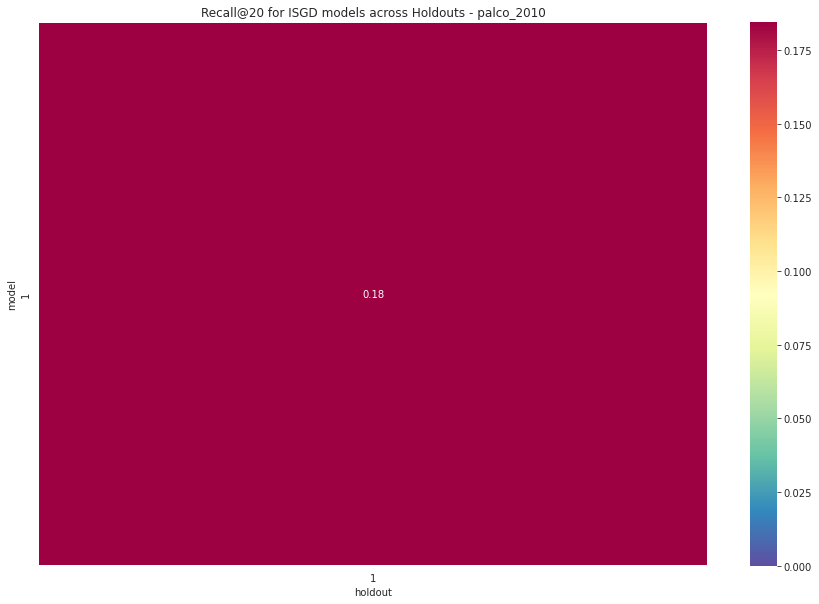

In [25]:
recall_heatmap(df,
    title='Recall@20 for ISGD models across Holdouts - palco_2010',
    filepath='images/heatmaps/palco2010/palco_2010 semester_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

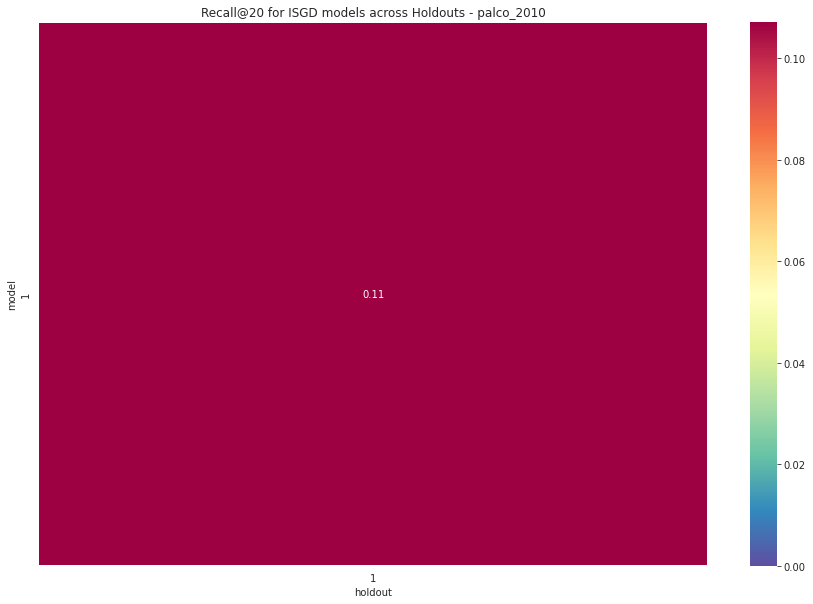

In [70]:
# old recall
recall_heatmap(df,
    title='Recall@20 for ISGD models across Holdouts - palco_2010',
    filepath='images/heatmaps/palco2010/palco_2010 semester_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

___
## Experiments using Fixed Bucket size


In [71]:
buckets, holdouts = getBucketsHoldouts(data=data, user_col=user_col, item_col=item_col, frequent_users=frequent_users_bucket, interval_type='F', intervals=fixed_bucket_intervals, cold_start_buckets=1)

### ISGD

In [72]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [73]:
# criamos instancia de EvaluateHoldouts para treinar modelos e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)
# 17 min

bucket 0
bucket 1
bucket 2
bucket 3
bucket 4
bucket 5
bucket 6
bucket 7
bucket 8
bucket 9
bucket 10
bucket 11


In [74]:
eval.EvaluateHoldouts(N_recommendations=20, exclude_known_items=True, default_user='none')

48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen


In [75]:
rm = eval.results_matrix
df = pd.DataFrame(rm.T)
df.to_csv('output/palco2010/palco_2010 fixed_bucket ISGD results.csv', index=False)
# df = pd.read_csv('output/palco2010/palco_2010 month_bucket ISGD results.csv')

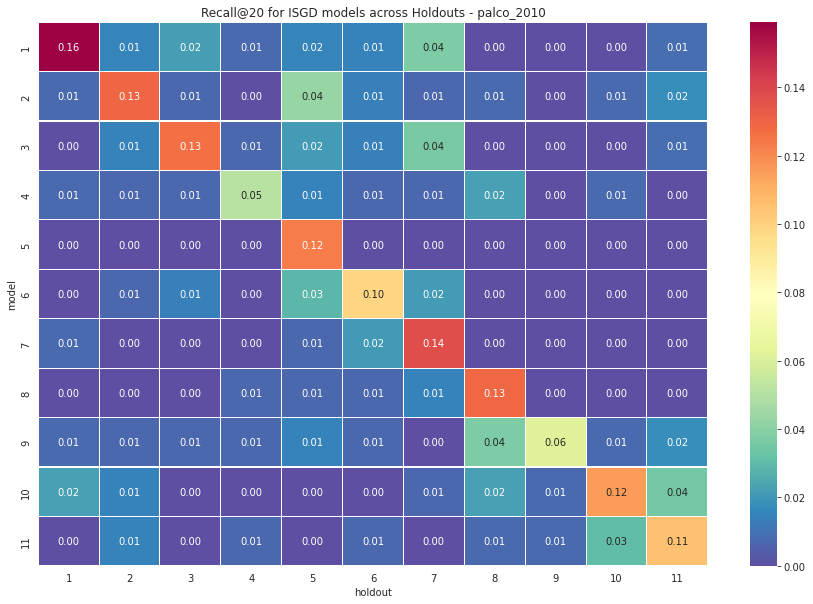

In [76]:
recall_heatmap(df,
    title='Recall@20 for ISGD models across Holdouts - palco_2010',
    filepath='images/heatmaps/palco2010/palco_2010 fixed_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [77]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.15151515151515152,
  -0.13709941137998694,
  -0.1311785398825626,
  -0.11670461589604568,
  -0.10794852209766745,
  -0.10877492062105447,
  -0.11287789328070982,
  -0.10831105812305662,
  -0.10469351236688085,
  -0.1057586965910097],
 -0.11848623217541257)

___

___
## old experiments

In [8]:
eval = EvaluateAndStore(model: Model, data: ImplicitData, n_holdouts: int = 20, metrics: Any = ["Recall@N"], N_recommendations: int = 20, seed: int = None)
# interações de 0 a 100 são usadas para pre treino. 
# count define numero de interações a serem usadas.
# holdouts e checkpoints são 
# store_only - somente guarda holdouts, não faz avaliação prequencial.
# default_user - Somente usado quando store_only = False durante avaliação prequencial.
_ = eval.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True)

In [9]:
#exclude_known_items -- boolean, exclude known items from recommendation
# default_user -- str. One of: random, average, or median. If user is not present in model (new user) user factors are generated.
eval.EvaluateHoldouts(exclude_known_items=True, default_user='none')

In [10]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1.T)
df.to_csv('output/palco_2010 ISGD results_matrix dfu_none.csv', index=False)

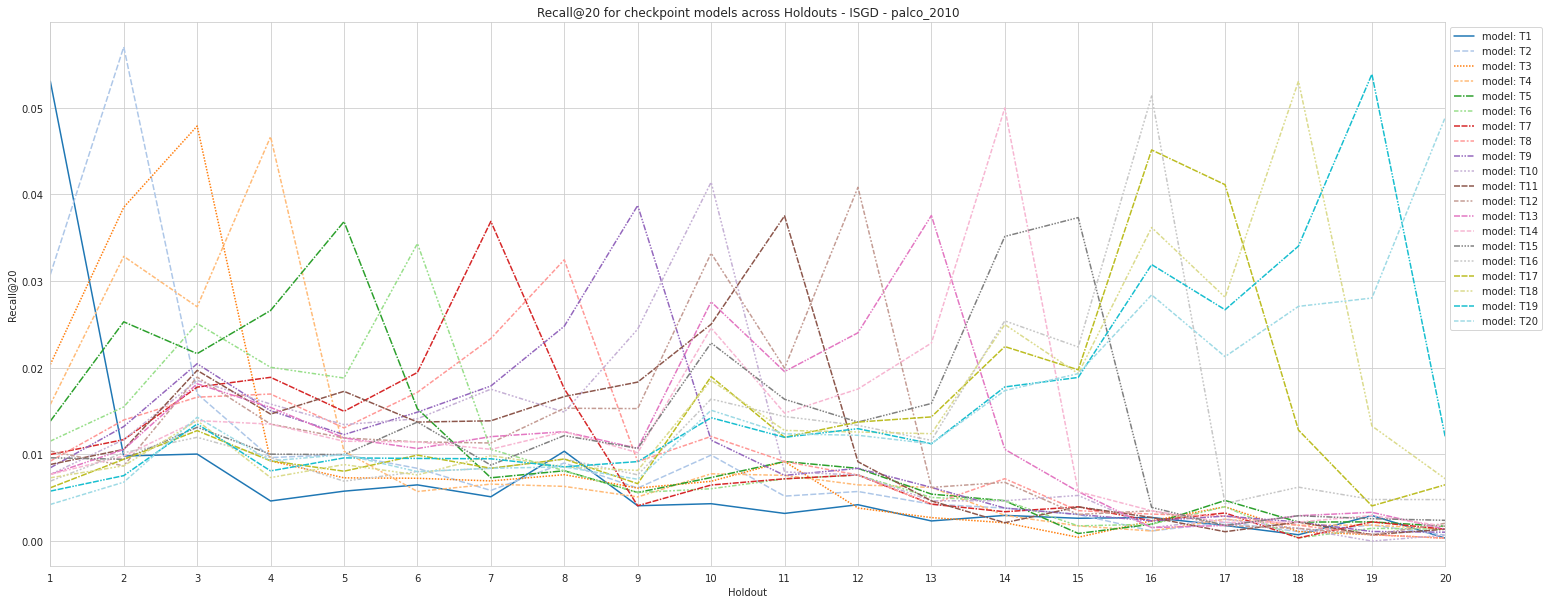

In [11]:
lineplot_recallxholdout(df,
    title='Recall@20 for checkpoint models across Holdouts - ISGD - palco_2010',
    filepath='images/lineplots/palco_2010 ISGD lineplot dfu_none.png'
    )

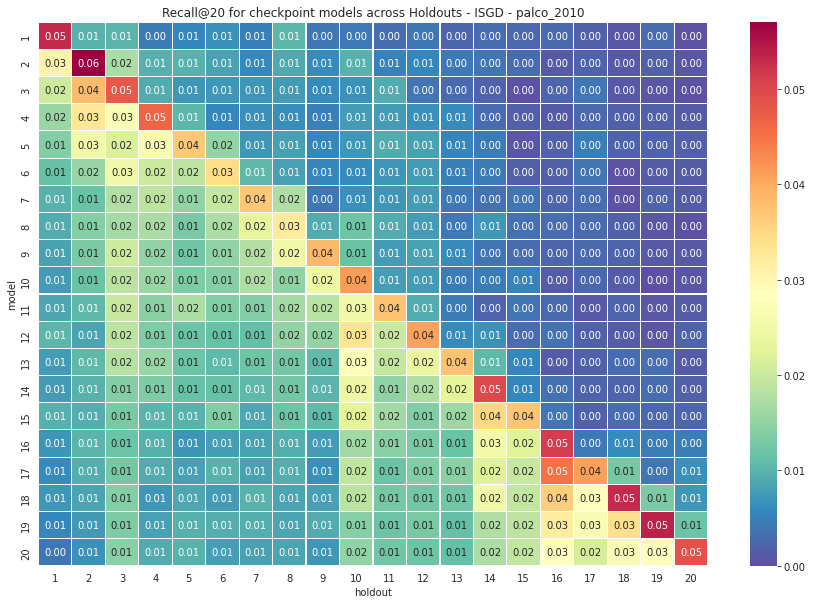

In [12]:
recall_heatmap(df,
    title='Recall@20 for checkpoint models across Holdouts - ISGD - palco_2010',
    filepath='images/heatmaps/palco_2010 ISGD heatmap dfu_none.png')

### default_user='random'

In [13]:
#exclude_known_items -- boolean, exclude known items from recommendation
# default_user -- str. One of: random, average, or median. If user is not present in model (new user) user factors are generated.
eval.EvaluateHoldouts(exclude_known_items=True, default_user='random')

In [14]:
rm = eval.results_matrix
df = pd.DataFrame(rm.T)
df.to_csv('output/palco_2010 ISGD results_matrix dfu_random.csv', index=False)

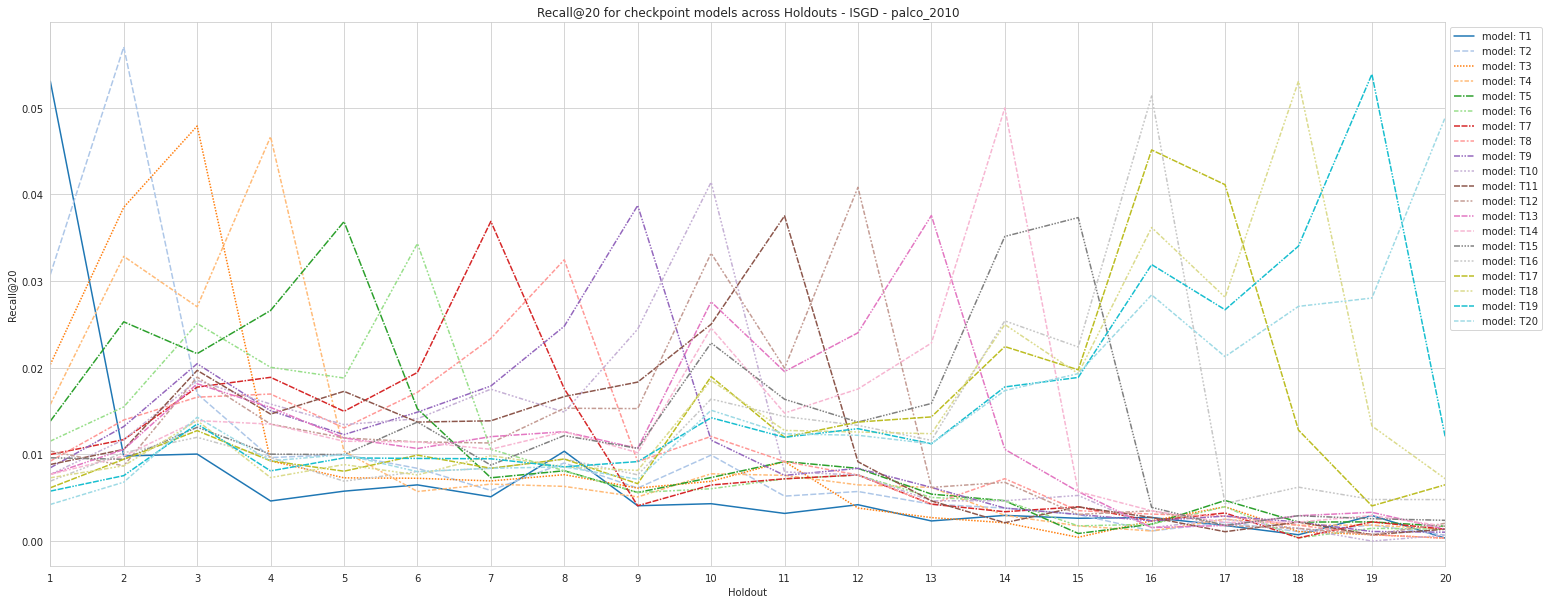

In [15]:
lineplot_recallxholdout(df,
    title='Recall@20 for checkpoint models across Holdouts - ISGD - palco_2010',
    filepath='images/lineplots/palco_2010 ISGD lineplot dfu_random.png'
    )

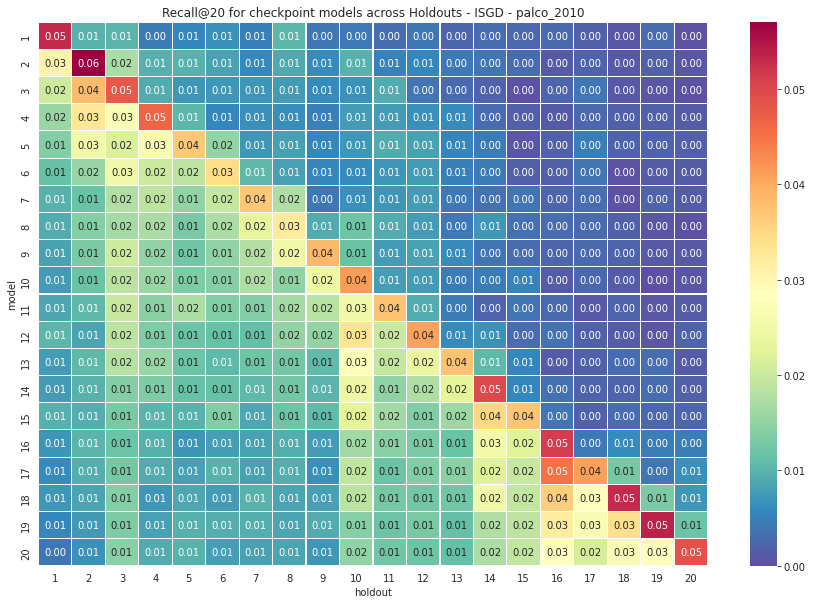

In [16]:
recall_heatmap(df,
    title='Recall@20 for checkpoint models across Holdouts - ISGD - palco_2010',
    filepath='images/heatmaps/palco_2010 ISGD heatmap dfu_random.png')

### default_user='average'

In [17]:
#exclude_known_items -- boolean, exclude known items from recommendation
# default_user -- str. One of: none, random, average, or median. If user is not present in model (new user) user factors are generated.
eval.EvaluateHoldouts(exclude_known_items=True, default_user='average')

In [18]:
rm = eval.results_matrix
df = pd.DataFrame(rm.T)
df.to_csv('output/palco_2010 ISGD results_matrix dfu_average.csv', index=False)

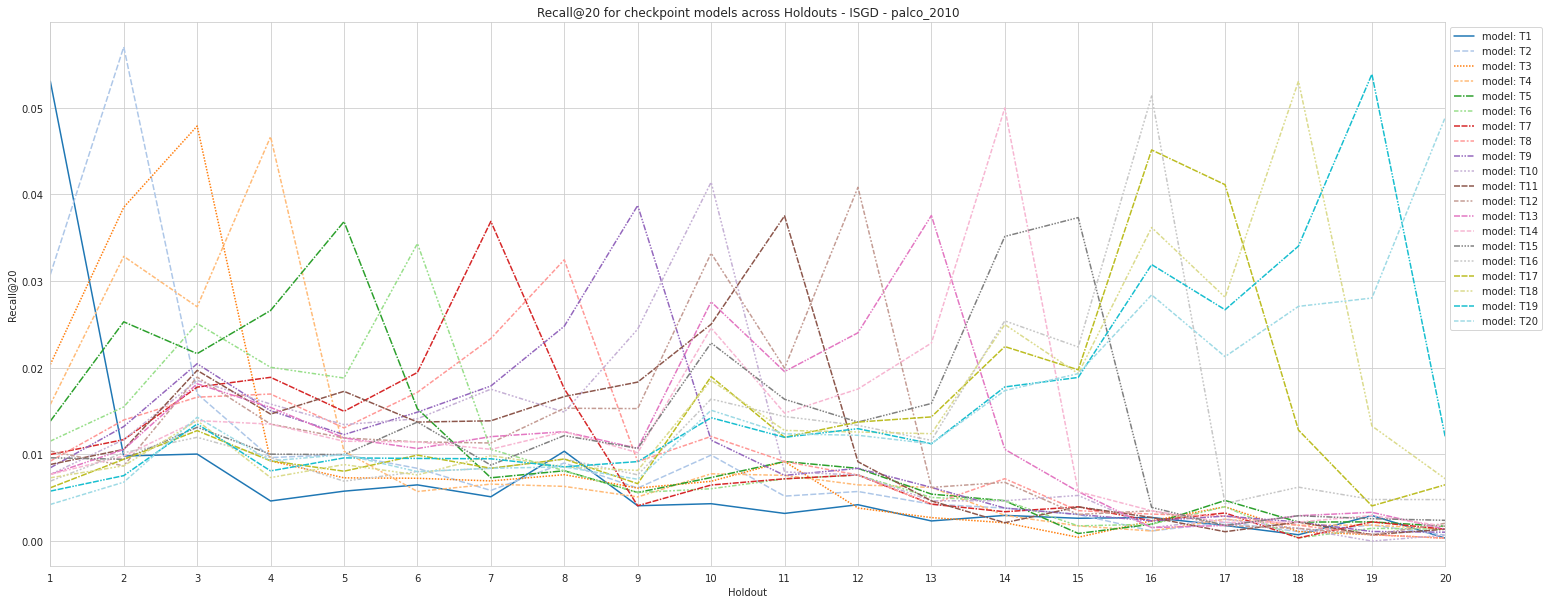

In [19]:
lineplot_recallxholdout(df,
    title='Recall@20 for checkpoint models across Holdouts - ISGD - palco_2010',
    filepath='images/lineplots/palco_2010 ISGD lineplot dfu_average.png'
    )

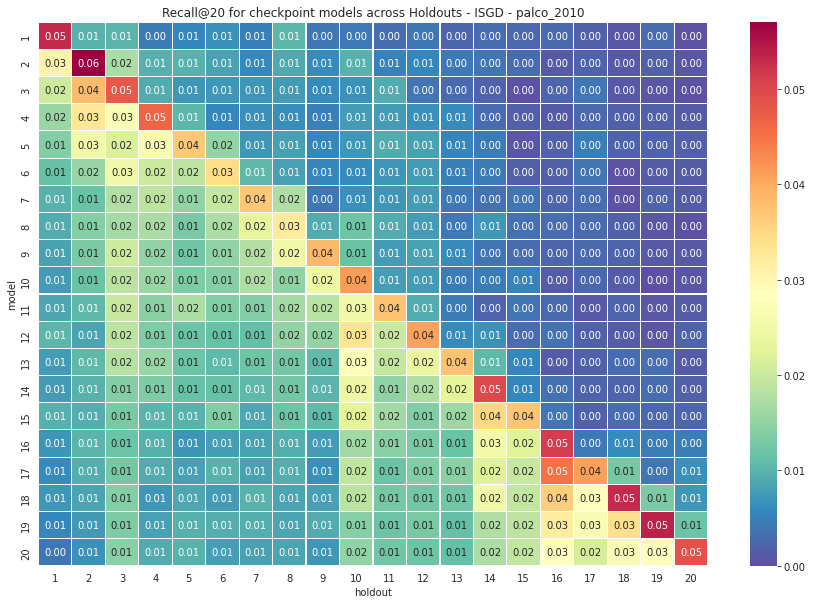

In [20]:
recall_heatmap(df,
    title='Recall@20 for checkpoint models across Holdouts - ISGD - palco_2010',
    filepath='images/heatmaps/palco_2010 ISGD heatmap dfu_average.png')

### default_user='median'

In [21]:
#exclude_known_items -- boolean, exclude known items from recommendation
# default_user -- str. One of: none, random, average, or median. If user is not present in model (new user) user factors are generated.
eval.EvaluateHoldouts(exclude_known_items=True, default_user='median')

In [22]:
rm = eval.results_matrix
df = pd.DataFrame(rm.T)
df.to_csv('output/palco_2010 ISGD results_matrix dfu_median.csv', index=False)

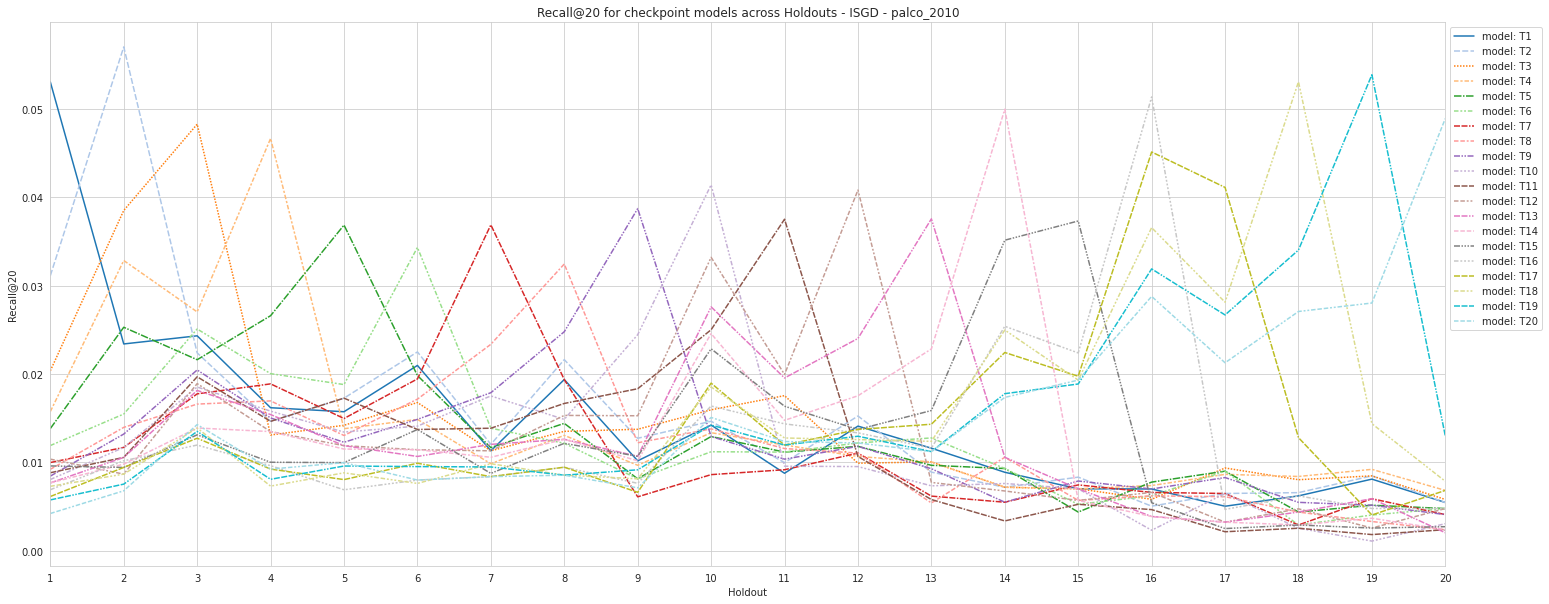

In [23]:
lineplot_recallxholdout(df,
    title='Recall@20 for checkpoint models across Holdouts - ISGD - palco_2010',
    filepath='images/lineplots/palco_2010 ISGD lineplot dfu_median.png'
    )

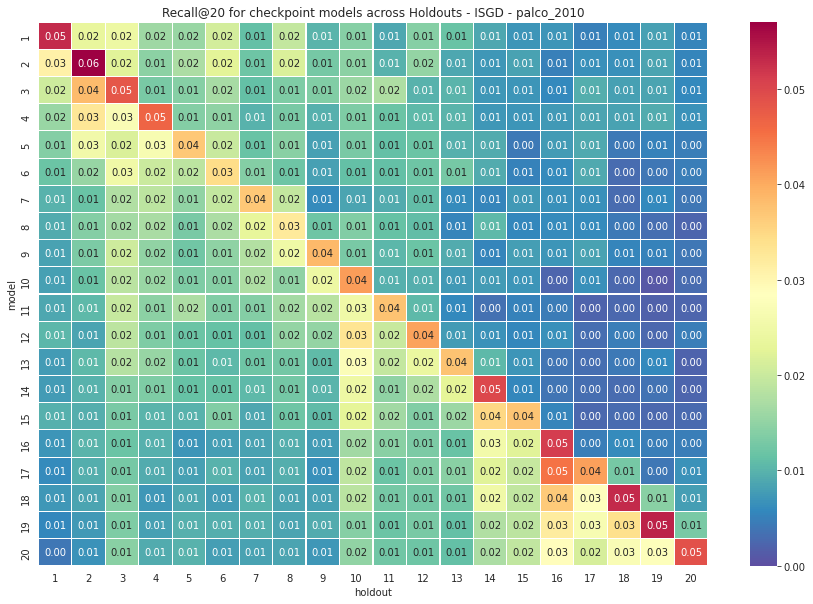

In [24]:
recall_heatmap(df,
    title='Recall@20 for checkpoint models across Holdouts - ISGD - palco_2010',
    filepath='images/heatmaps/palco_2010 ISGD heatmap dfu_median.png')

___
### RSISGD

### default_user='none'

In [5]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
# stream = ImplicitData(data['UserID'].to_list(), data['ItemID'].to_list())
stream = ImplicitData(data['user_id'], data['track_id'])

empty_stream = ImplicitData([], [])

In [6]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = RSISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10, ra_length=1)

In [7]:
# criamos instancia de EvaluateAndStore para criar holdouts com o método EvaluateAndStore
eval = EvaluateAndStore(model=model, data=stream, n_holdouts=20, metrics=["Recall@N"], N_recommendations=20, seed=42)

In [8]:
# interações de 0 a 100 são usadas para pre treino. 
# count define numero de interações a serem usadas.
# holdouts e checkpoints são 
# store_only - somente guarda holdouts, não faz avaliação prequencial.
# default_user - Somente usado quando store_only = False durante avaliação prequencial.
_ = eval.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True)

In [29]:
#exclude_known_items -- boolean, exclude known items from recommendation
# default_user -- str. One of: random, average, or median. If user is not present in model (new user) user factors are generated.
eval.EvaluateHoldouts(exclude_known_items=True, default_user='none')

In [30]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1.T)
df.to_csv('output/palco_2010 RSISGD results_matrix dfu_none.csv', index=False)

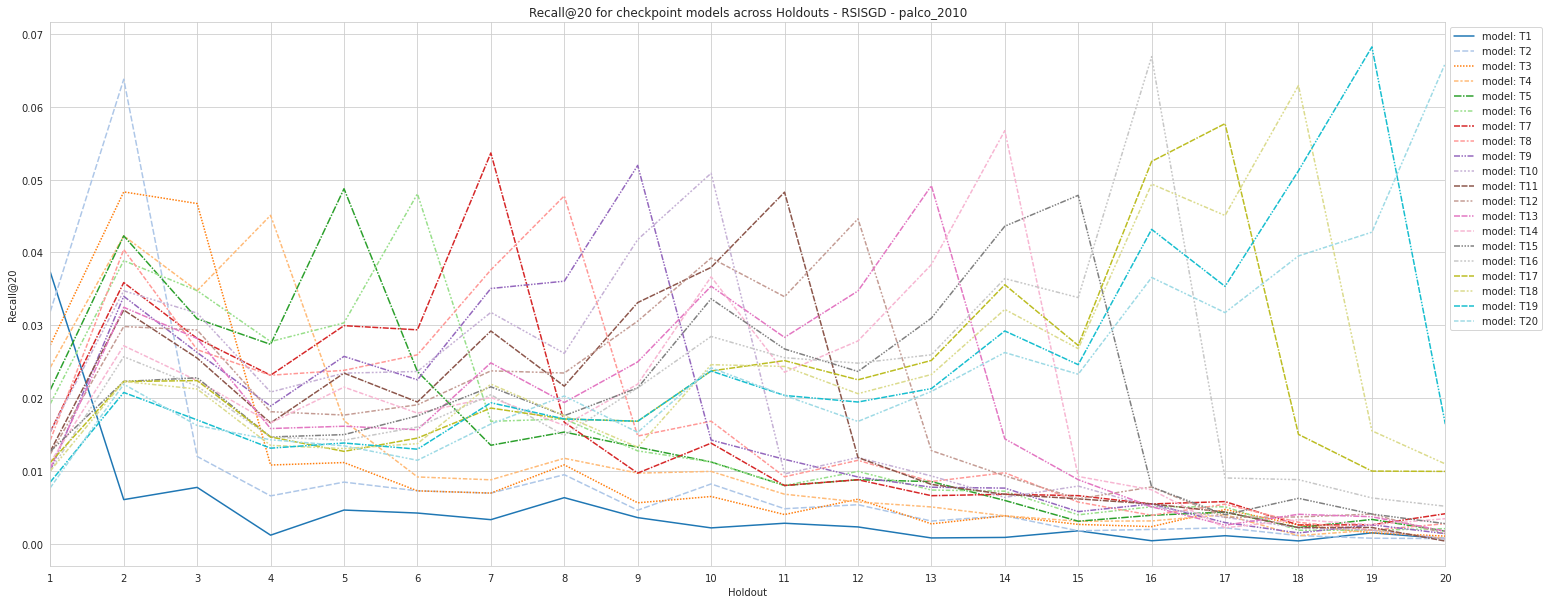

In [31]:
lineplot_recallxholdout(df,
    title='Recall@20 for checkpoint models across Holdouts - RSISGD - palco_2010',
    filepath='images/lineplots/palco_2010 RSISGD lineplot dfu_none.png'
    )

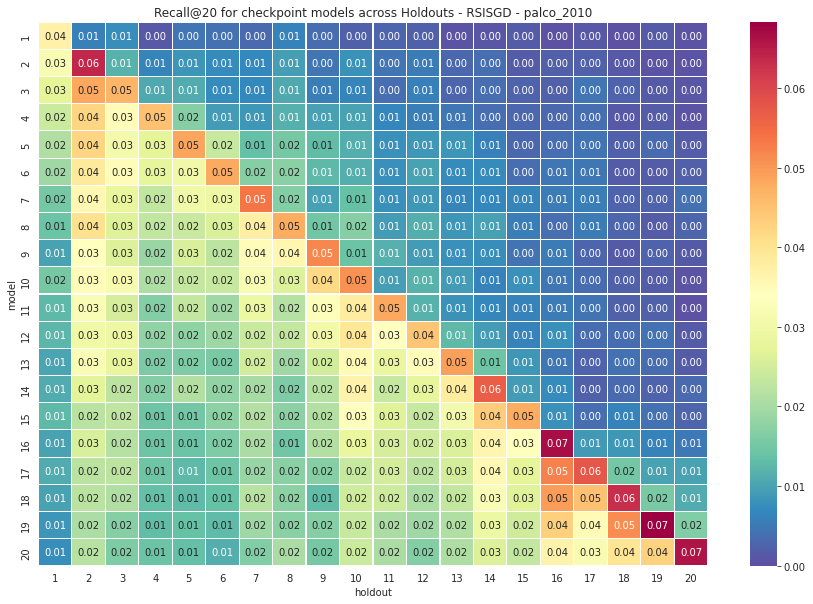

In [32]:
recall_heatmap(df,
    title='Recall@20 for checkpoint models across Holdouts - RSISGD - palco_2010',
    filepath='images/heatmaps/palco_2010 RSISGD heatmap dfu_none.png')

### default_user='random'

In [33]:
#exclude_known_items -- boolean, exclude known items from recommendation
# default_user -- str. One of: random, average, or median. If user is not present in model (new user) user factors are generated.
eval.EvaluateHoldouts(exclude_known_items=True, default_user='random')

In [34]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1.T)
df.to_csv('output/palco_2010 RSISGD results_matrix dfu_random.csv', index=False)

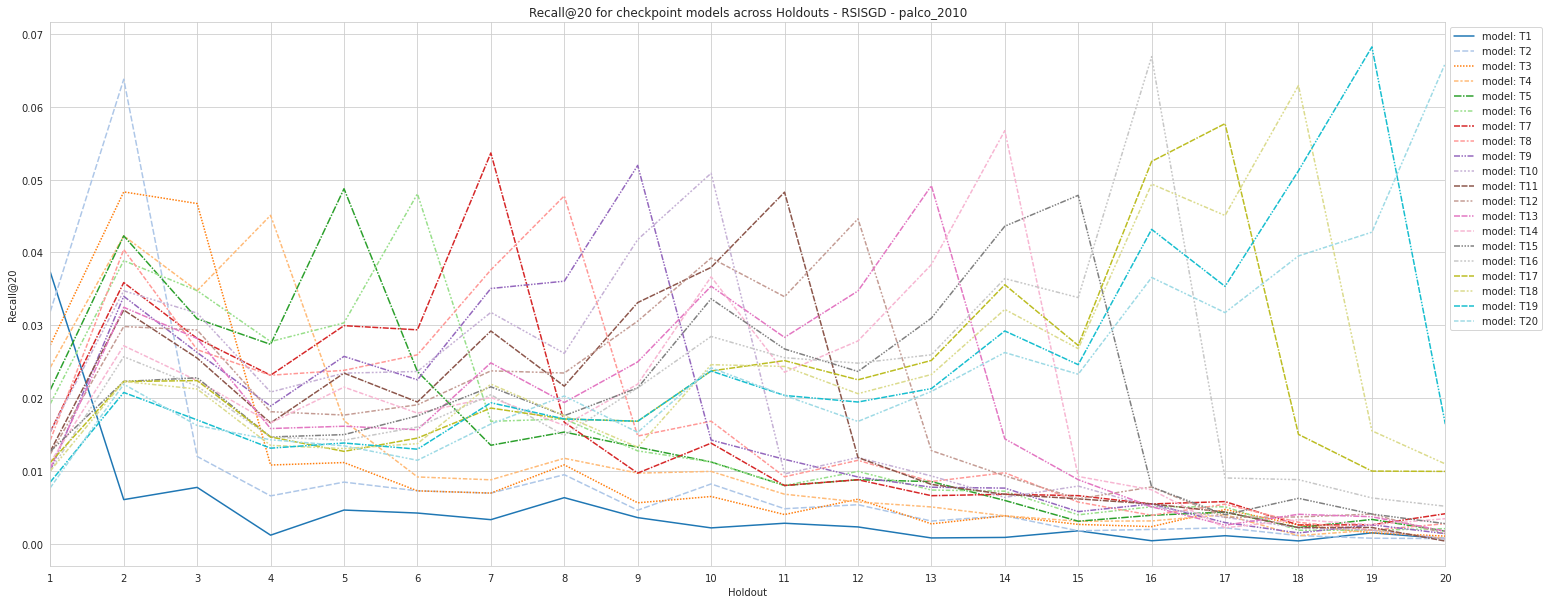

In [35]:
lineplot_recallxholdout(df,
    title='Recall@20 for checkpoint models across Holdouts - RSISGD - palco_2010',
    filepath='images/lineplots/palco_2010 RSISGD lineplot dfu_random.png'
    )

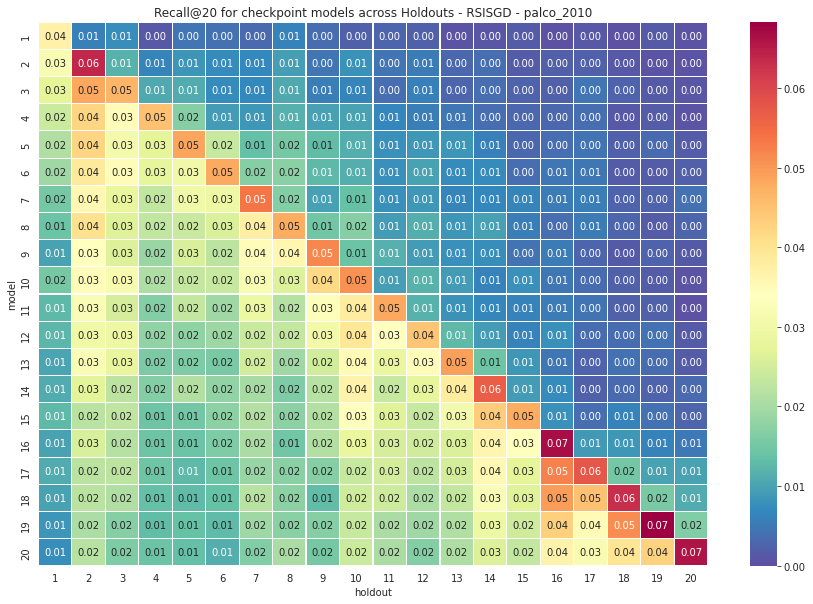

In [36]:
recall_heatmap(df,
    title='Recall@20 for checkpoint models across Holdouts - RSISGD - palco_2010',
    filepath='images/heatmaps/palco_2010 RSISGD heatmap dfu_random.png')

### default_user='average'

In [9]:
#exclude_known_items -- boolean, exclude known items from recommendation
# default_user -- str. One of: random, average, or median. If user is not present in model (new user) user factors are generated.
eval.EvaluateHoldouts(exclude_known_items=True, default_user='average')

In [10]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1.T)
df.to_csv('output/palco_2010 RSISGD results_matrix dfu_average.csv', index=False)

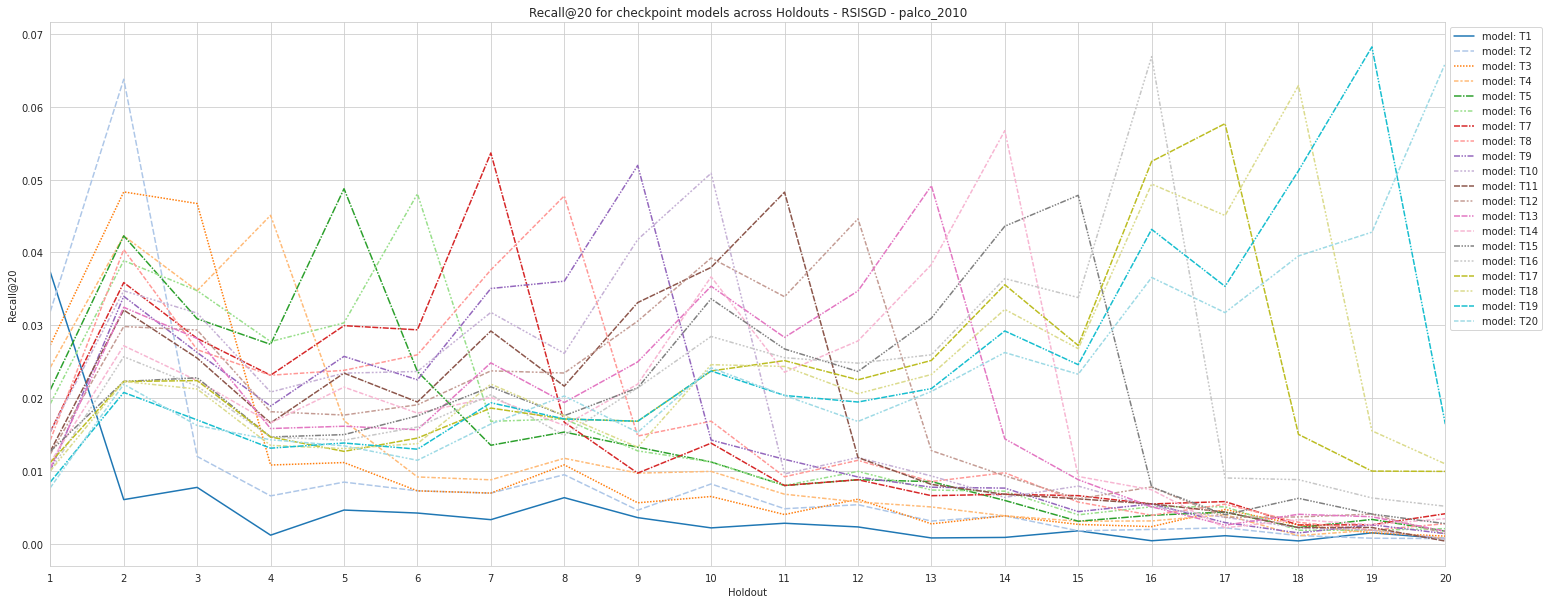

In [11]:
lineplot_recallxholdout(df,
    title='Recall@20 for checkpoint models across Holdouts - RSISGD - palco_2010',
    filepath='images/lineplots/palco_2010 RSISGD lineplot dfu_average.png'
    )

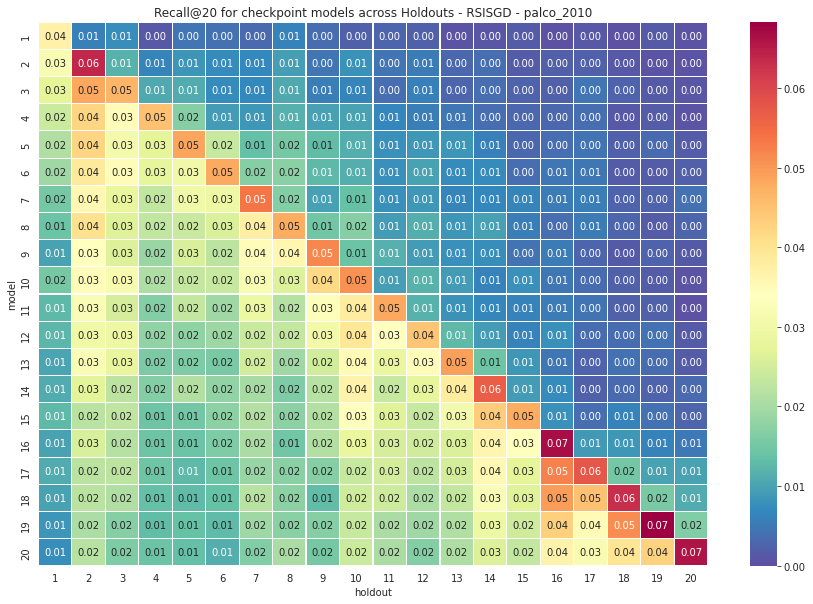

In [12]:
recall_heatmap(df,
    title='Recall@20 for checkpoint models across Holdouts - RSISGD - palco_2010',
    filepath='images/heatmaps/palco_2010 RSISGD heatmap dfu_average.png')

### default_user='median'

In [13]:
#exclude_known_items -- boolean, exclude known items from recommendation
# default_user -- str. One of: random, average, or median. If user is not present in model (new user) user factors are generated.
eval.EvaluateHoldouts(exclude_known_items=True, default_user='median')

In [14]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1.T)
df.to_csv('output/palco_2010 RSISGD results_matrix dfu_median.csv', index=False)

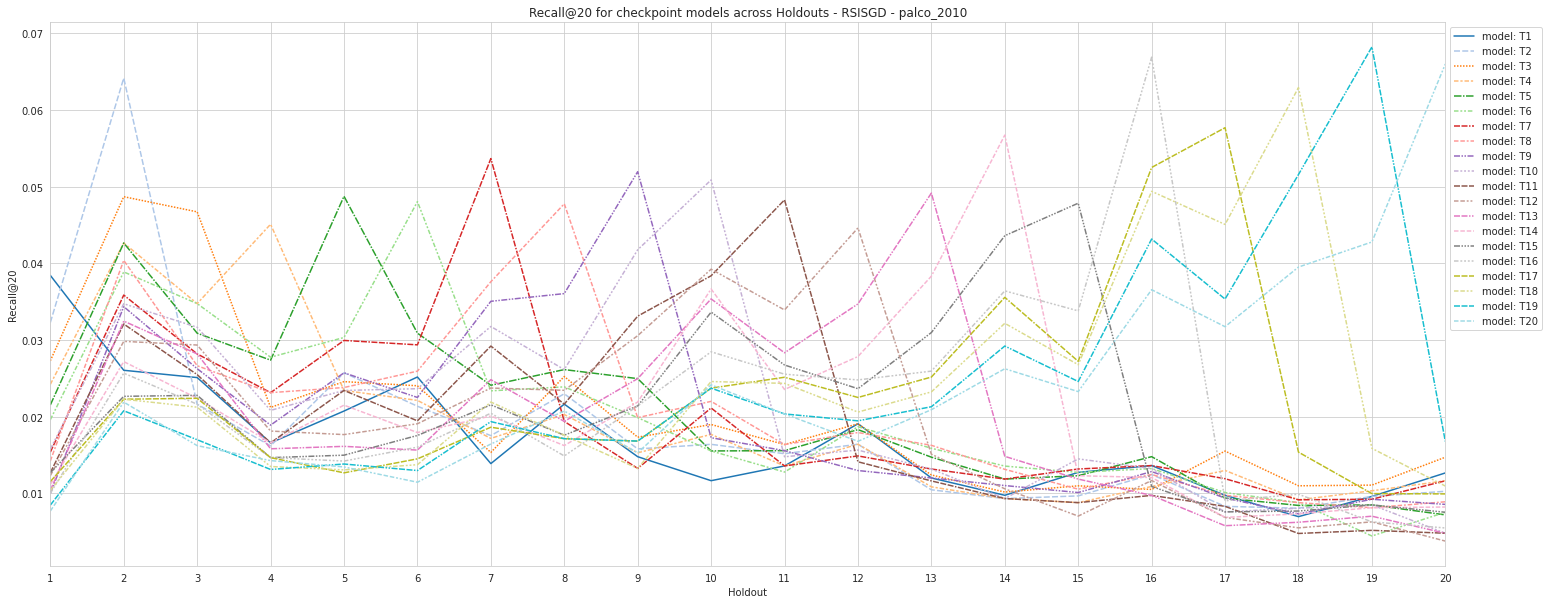

In [15]:
lineplot_recallxholdout(df,
    title='Recall@20 for checkpoint models across Holdouts - RSISGD - palco_2010',
    filepath='images/lineplots/palco_2010 RSISGD lineplot dfu_median.png'
    )

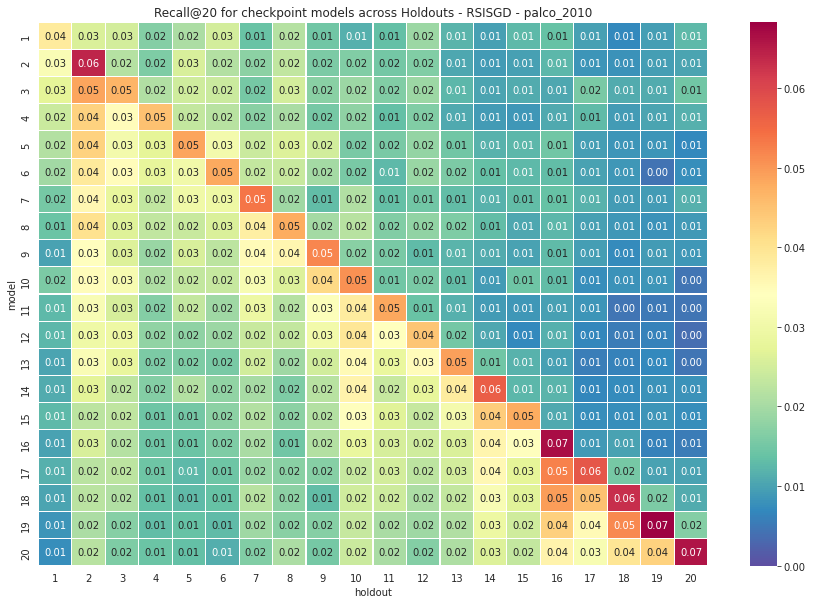

In [16]:
recall_heatmap(df,
    title='Recall@20 for checkpoint models across Holdouts - RSISGD - palco_2010',
    filepath='images/heatmaps/palco_2010 RSISGD heatmap dfu_median.png')

___
### RAISGD

### default_user='none'

In [17]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
# stream = ImplicitData(data['UserID'].to_list(), data['ItemID'].to_list())
stream = ImplicitData(data['user_id'], data['track_id'])

empty_stream = ImplicitData([], [])

In [18]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = RAISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10, ra_length=1)

In [19]:
# criamos instancia de EvaluateAndStore para criar holdouts com o método EvaluateAndStore
eval = EvaluateAndStore(model=model, data=stream, n_holdouts=20, metrics=["Recall@N"], N_recommendations=20, seed=42)

In [20]:
# interações de 0 a 100 são usadas para pre treino. 
# count define numero de interações a serem usadas.
# holdouts e checkpoints são 
# store_only - somente guarda holdouts, não faz avaliação prequencial.
# default_user - Somente usado quando store_only = False durante avaliação prequencial.
_ = eval.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True)

In [21]:
#exclude_known_items -- boolean, exclude known items from recommendation
# default_user -- str. One of: random, average, or median. If user is not present in model (new user) user factors are generated.
eval.EvaluateHoldouts(exclude_known_items=True, default_user='none')

In [22]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1.T)
df.to_csv('output/palco_2010 RAISGD results_matrix dfu_none.csv', index=False)

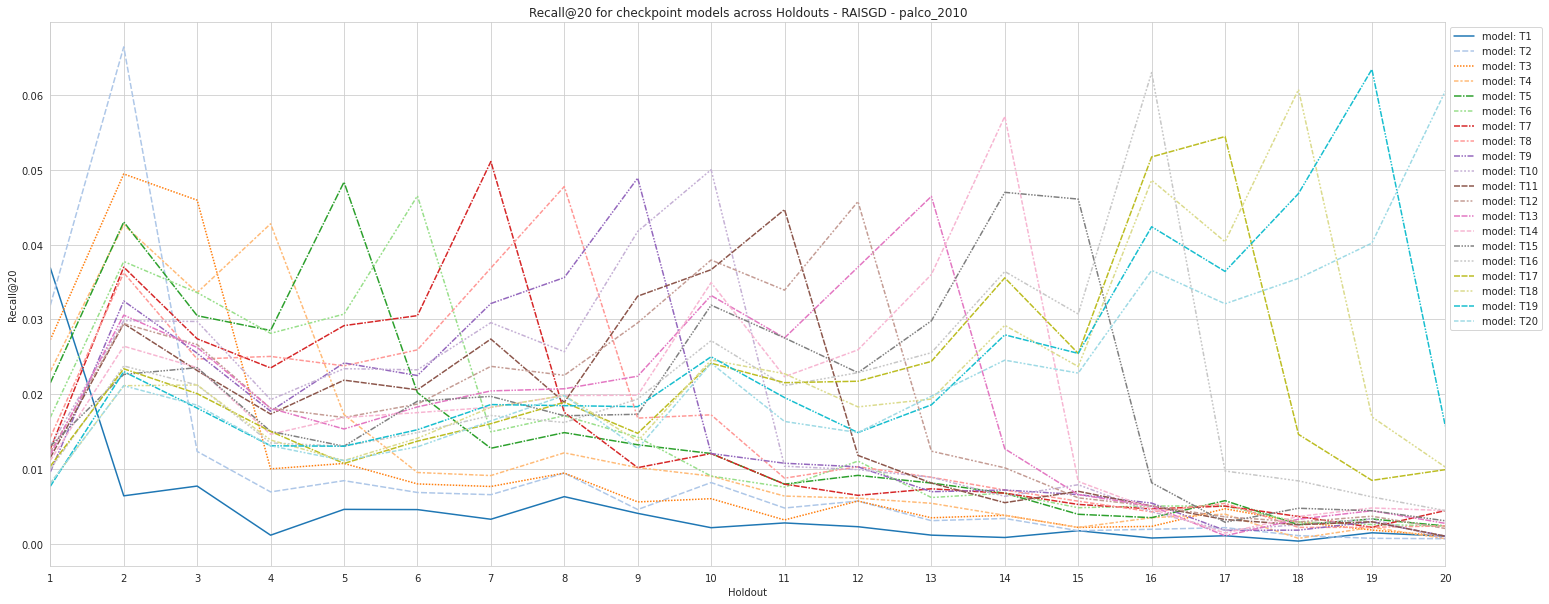

In [23]:
lineplot_recallxholdout(df,
    title='Recall@20 for checkpoint models across Holdouts - RAISGD - palco_2010',
    filepath='images/lineplots/palco_2010 RAISGD lineplot dfu_none.png'
    )

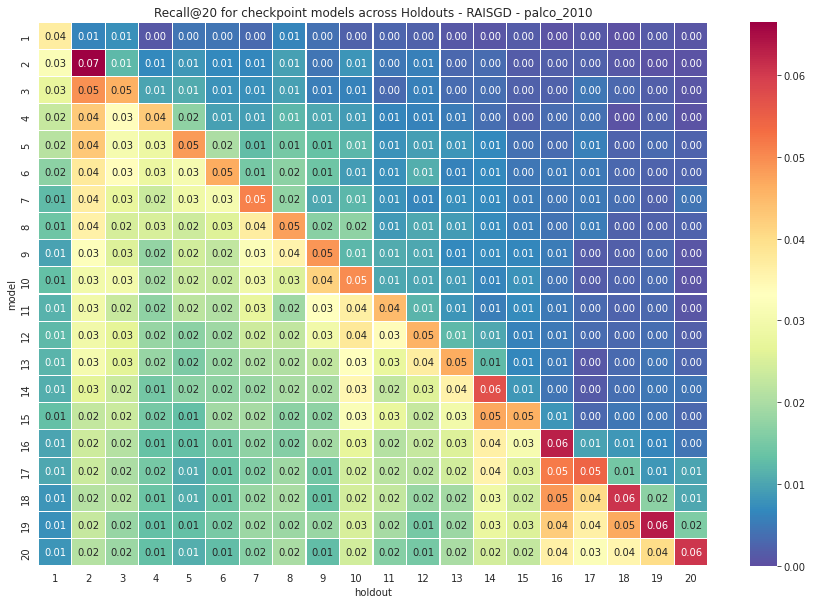

In [24]:
recall_heatmap(df,
    title='Recall@20 for checkpoint models across Holdouts - RAISGD - palco_2010',
    filepath='images/heatmaps/palco_2010 RAISGD heatmap dfu_none.png')

### default_user='random'

In [25]:
#exclude_known_items -- boolean, exclude known items from recommendation
# default_user -- str. One of: random, average, or median. If user is not present in model (new user) user factors are generated.
eval.EvaluateHoldouts(exclude_known_items=True, default_user='random')

In [26]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1.T)
df.to_csv('output/palco_2010 RAISGD results_matrix dfu_random.csv', index=False)

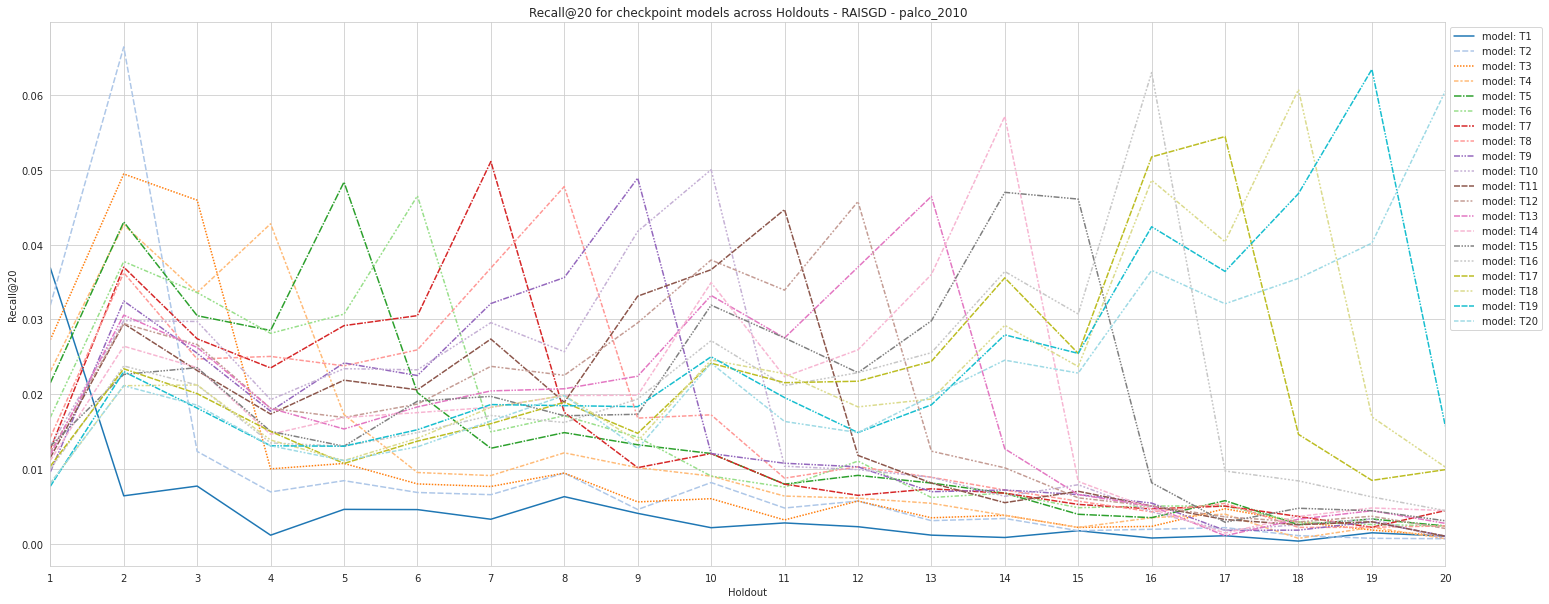

In [27]:
lineplot_recallxholdout(df,
    title='Recall@20 for checkpoint models across Holdouts - RAISGD - palco_2010',
    filepath='images/lineplots/palco_2010 RAISGD lineplot dfu_random.png'
    )

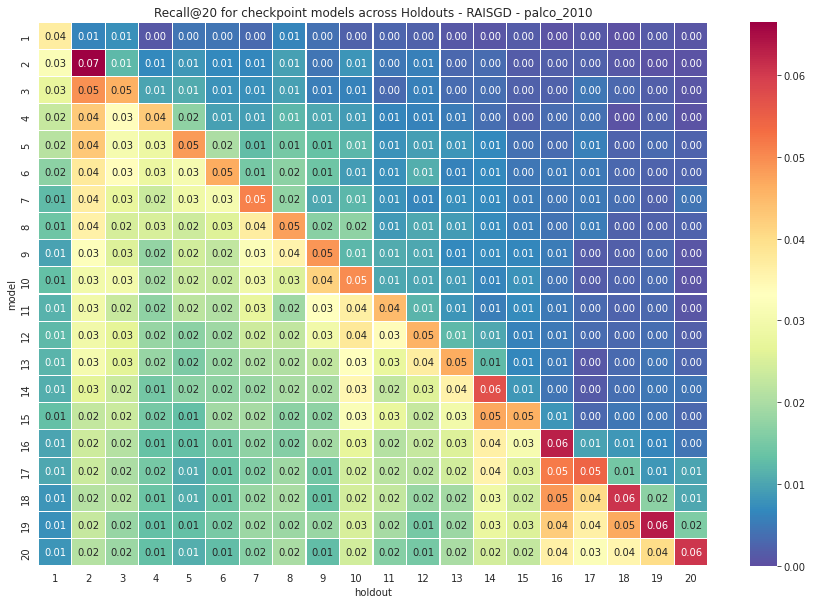

In [28]:
recall_heatmap(df,
    title='Recall@20 for checkpoint models across Holdouts - RAISGD - palco_2010',
    filepath='images/heatmaps/palco_2010 RAISGD heatmap dfu_random.png')

### default_user='average'

In [29]:
#exclude_known_items -- boolean, exclude known items from recommendation
# default_user -- str. One of: random, average, or median. If user is not present in model (new user) user factors are generated.
eval.EvaluateHoldouts(exclude_known_items=True, default_user='average')

In [30]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1.T)
df.to_csv('output/palco_2010 RAISGD results_matrix dfu_average.csv', index=False)

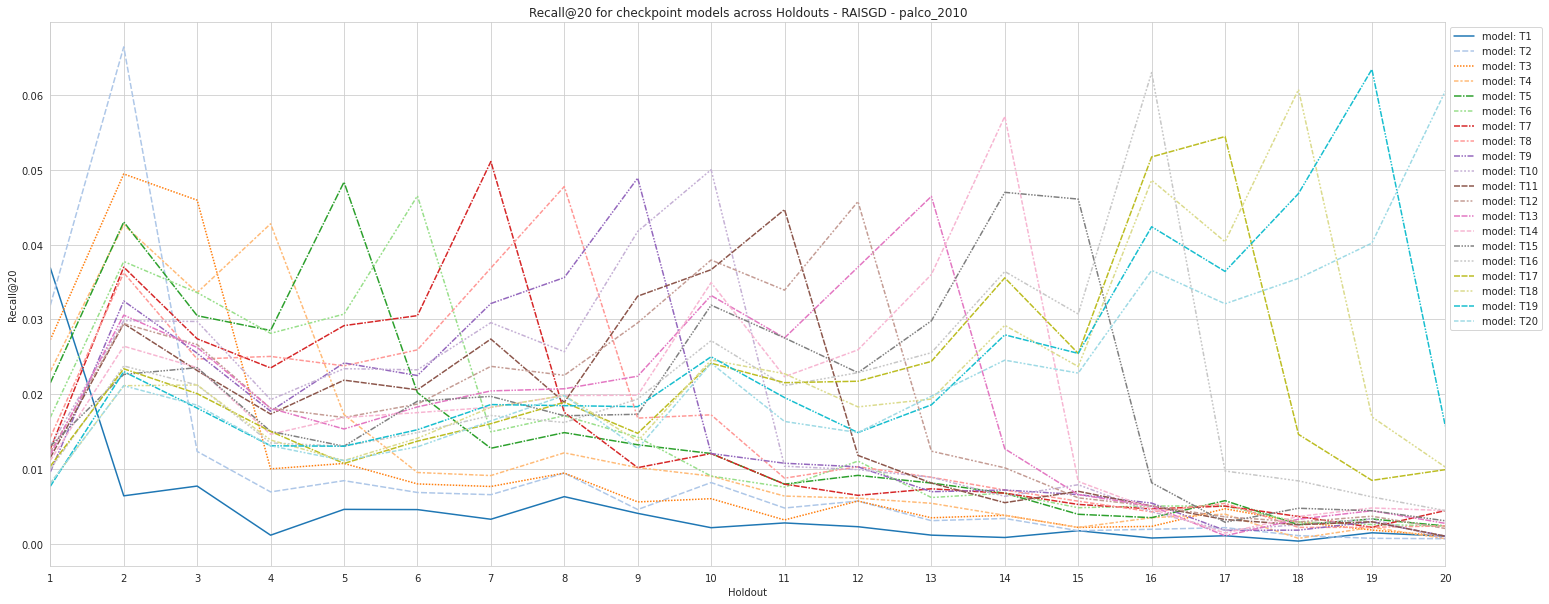

In [31]:
lineplot_recallxholdout(df,
    title='Recall@20 for checkpoint models across Holdouts - RAISGD - palco_2010',
    filepath='images/lineplots/palco_2010 RAISGD lineplot dfu_average.png'
    )

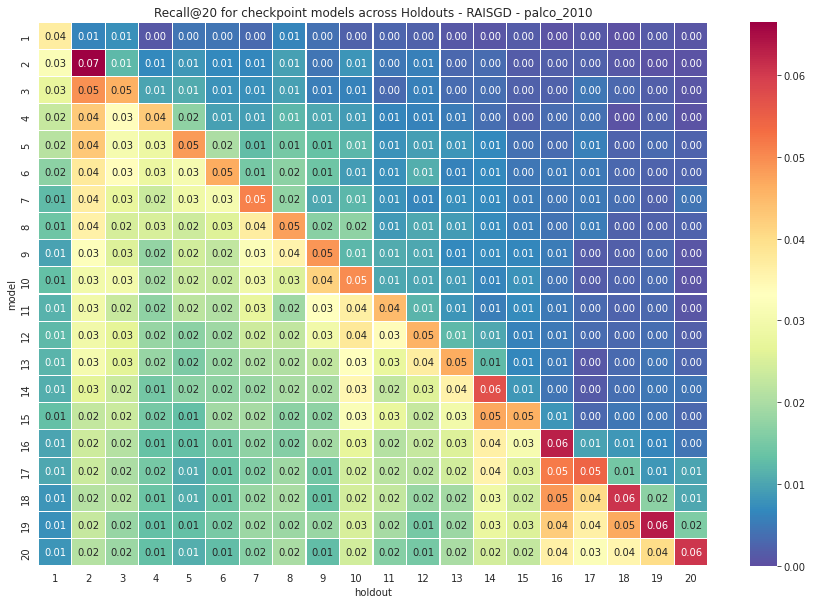

In [32]:
recall_heatmap(df,
    title='Recall@20 for checkpoint models across Holdouts - RAISGD - palco_2010',
    filepath='images/heatmaps/palco_2010 RAISGD heatmap dfu_average.png')

### default_user='median'

In [33]:
#exclude_known_items -- boolean, exclude known items from recommendation
# default_user -- str. One of: random, average, or median. If user is not present in model (new user) user factors are generated.
eval.EvaluateHoldouts(exclude_known_items=True, default_user='median')

In [34]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1.T)
df.to_csv('output/palco_2010 RAISGD results_matrix dfu_median.csv', index=False)

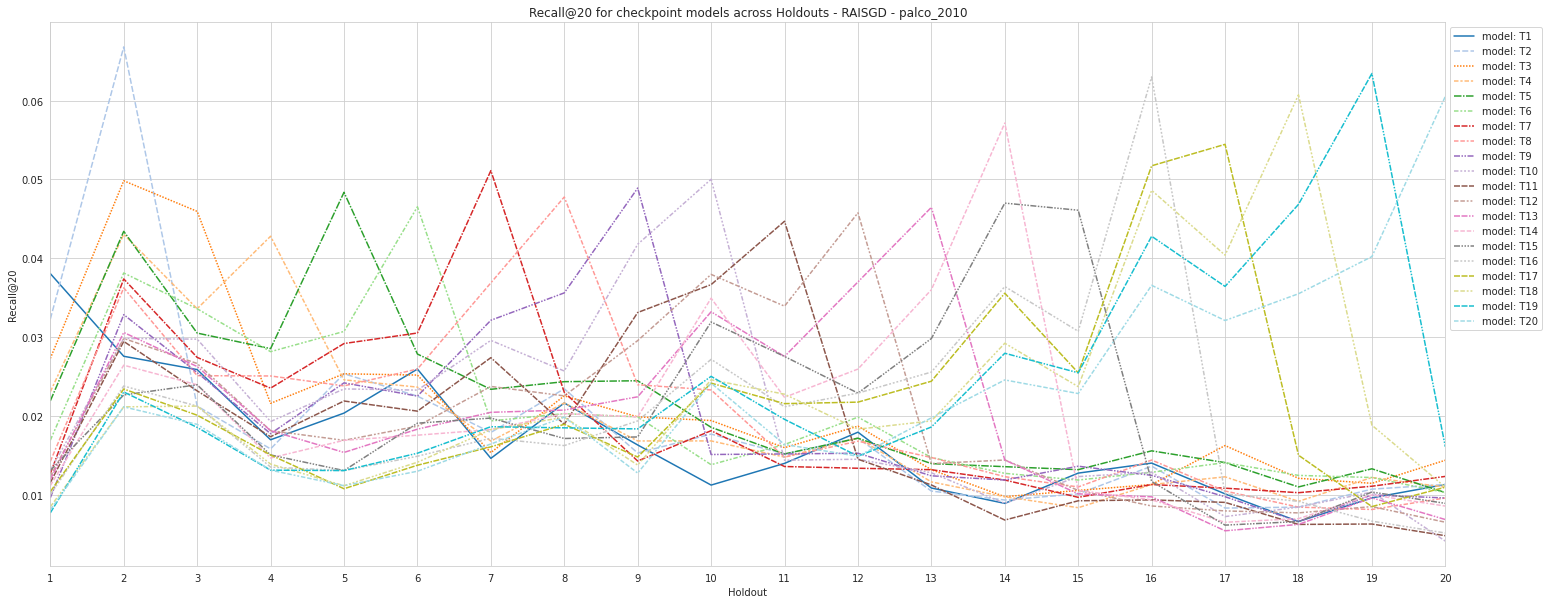

In [35]:
lineplot_recallxholdout(df,
    title='Recall@20 for checkpoint models across Holdouts - RAISGD - palco_2010',
    filepath='images/lineplots/palco_2010 RAISGD lineplot dfu_median.png'
    )

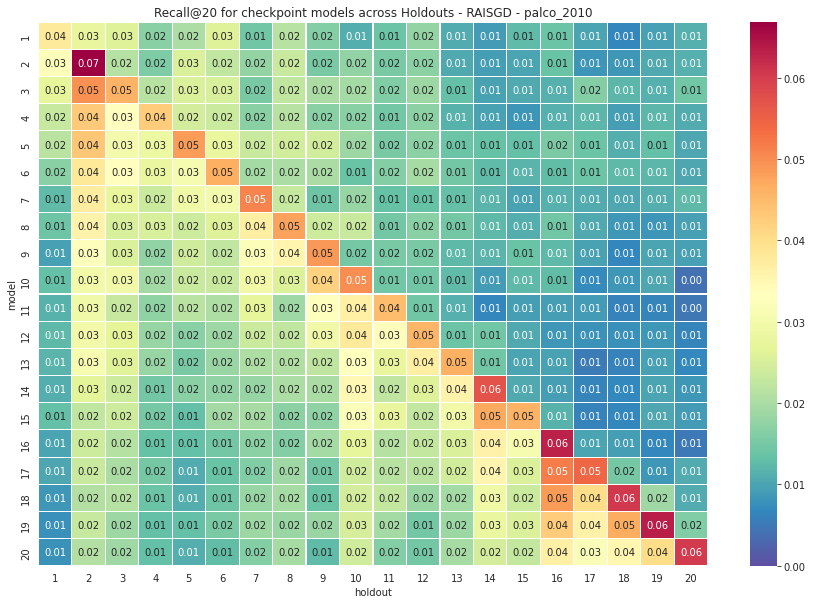

In [36]:
recall_heatmap(df,
    title='Recall@20 for checkpoint models across Holdouts - RAISGD - palco_2010',
    filepath='images/heatmaps/palco_2010 RAISGD heatmap dfu_median.png')

___
### Euclidean Distance

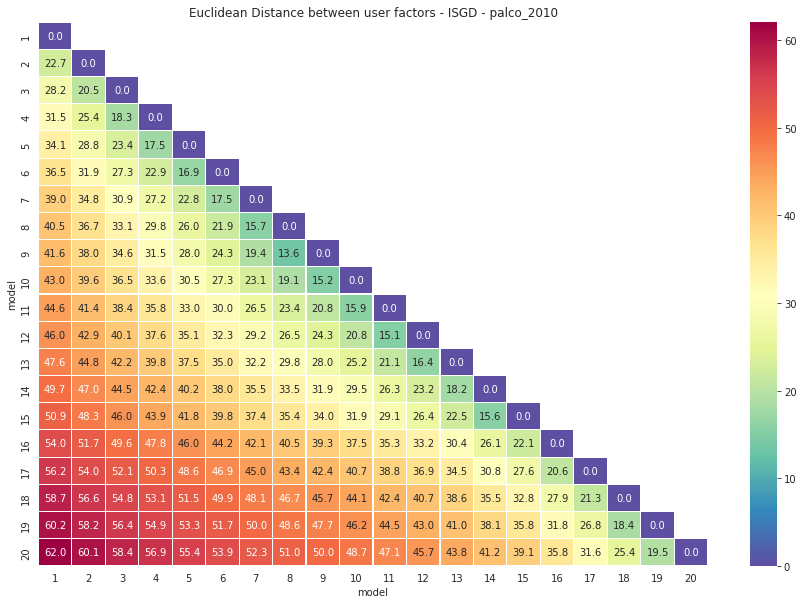

In [13]:
mask = np.zeros_like(user_factor_diff, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False
plt.figure(figsize=(15, 10))
sns.heatmap( user_factor_diff.T, mask=mask, annot=True, fmt='0.1f', linewidths=.1, cmap='Spectral_r', xticklabels=labels, yticklabels=labels) 
plt.ylabel('model')
plt.xlabel('model')
plt.title('Euclidean Distance between user factors - ISGD - palco_2010');
plt.savefig('output/ED user_factors heatmap palco_2010');

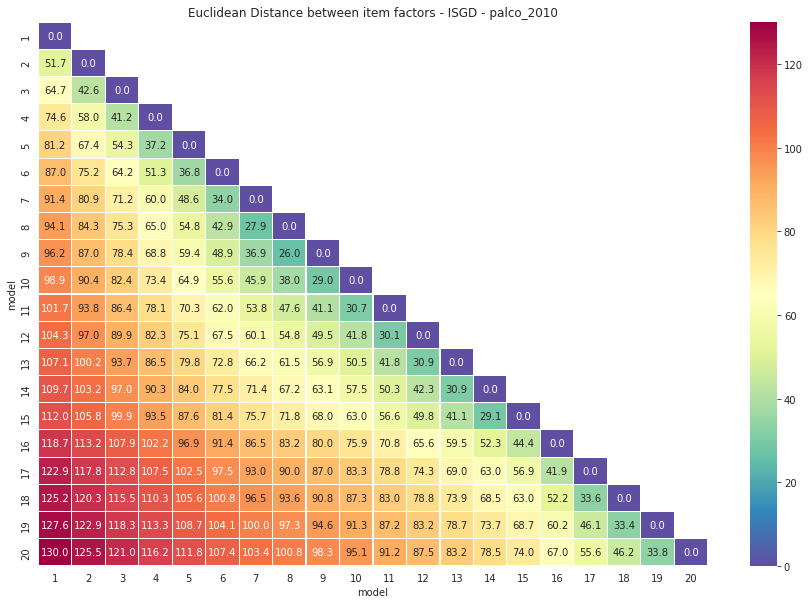

In [14]:
mask = np.zeros_like(user_factor_diff, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False
plt.figure(figsize=(15, 10))
sns.heatmap( item_factor_diff.T, mask=mask, annot=True, fmt='0.1f', linewidths=.1, cmap='Spectral_r', xticklabels=labels, yticklabels=labels) 
plt.ylabel('model')
plt.xlabel('model')
plt.title('Euclidean Distance between item factors - ISGD - palco_2010');
plt.savefig('output/ED item_factors heatmap palco_2010');

___

___
### Shuffled Dataset

In [15]:
shuffled_data = data.sample(frac=1).reset_index(drop=True).copy()

In [16]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
stream = ImplicitData(shuffled_data['user_id'].to_list(), shuffled_data['track_id'].to_list())

empty_stream = ImplicitData([], [])

In [17]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [18]:
eval = EvaluateAndStore(model=model,data=stream,n_holdouts=20,metrics = ["Recall@20"])

In [19]:
results=eval.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True)

A seguir calculamos uma matrix de resultados - todos os checkpoints de modelo avaliados em todos os holdouts.
Exclude known items está LIGADO.

In [20]:
eval.EvaluateHoldouts(exclude_known_items=True)

KeyboardInterrupt: 

In [ ]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1)
df.to_csv('output/shuffled palco_2010 results_matrix.csv', index=False)

In [ ]:
# # Read results:
# rm1 = pd.read_csv('output/shuffled palco_2010 results_matrix.csv')

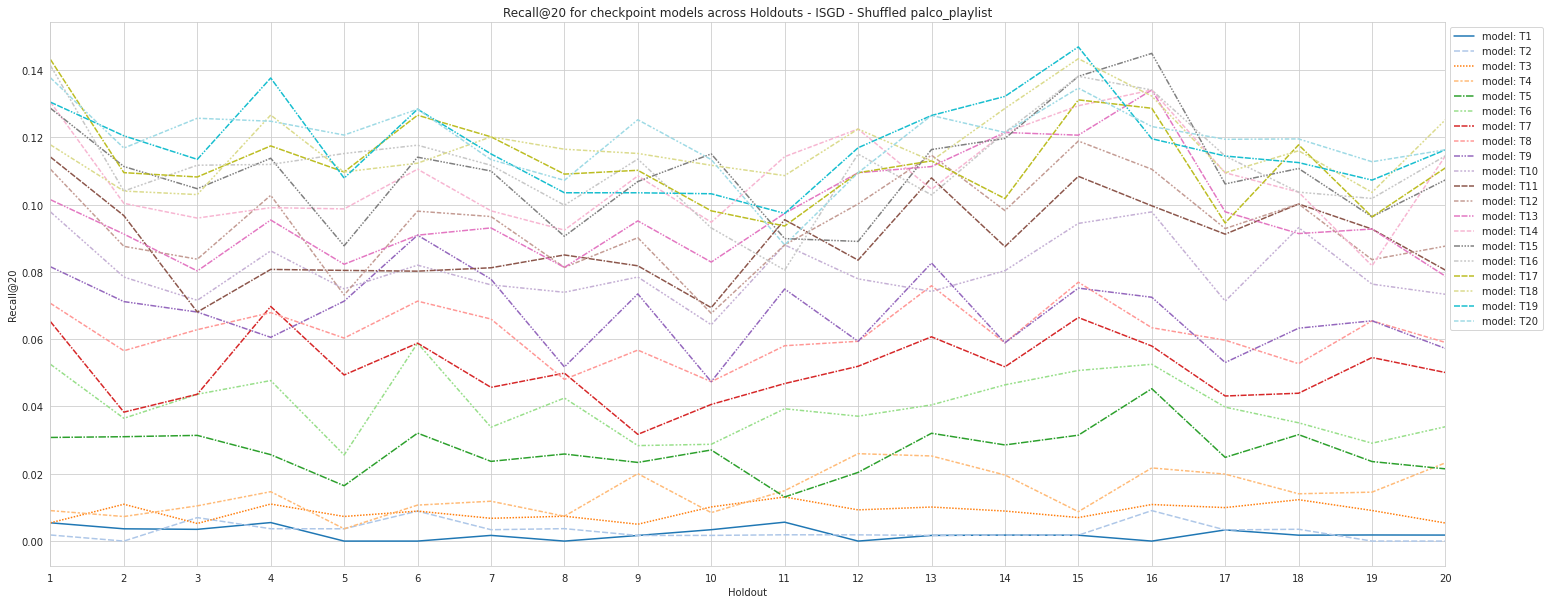

In [ ]:
plt.figure(figsize=(25,10))
sns.lineplot(data=rm1, palette='tab20')
x_t = np.arange(0,20)
plt.xticks(x_t, labels=[str(i+1) for i in x_t])
plt.xlim(0, 19)
plt.xlabel('Holdout')
plt.ylabel('Recall@20')
plt.legend(bbox_to_anchor=(1.0,1), loc="upper left", labels=[f'model: T{model+1}' for model in range( rm1.shape[0] )])
plt.title('Recall@20 for checkpoint models across Holdouts - ISGD - Shuffled palco_2010')
plt.savefig('output/recall20 lineplot shuffled palco_2010');

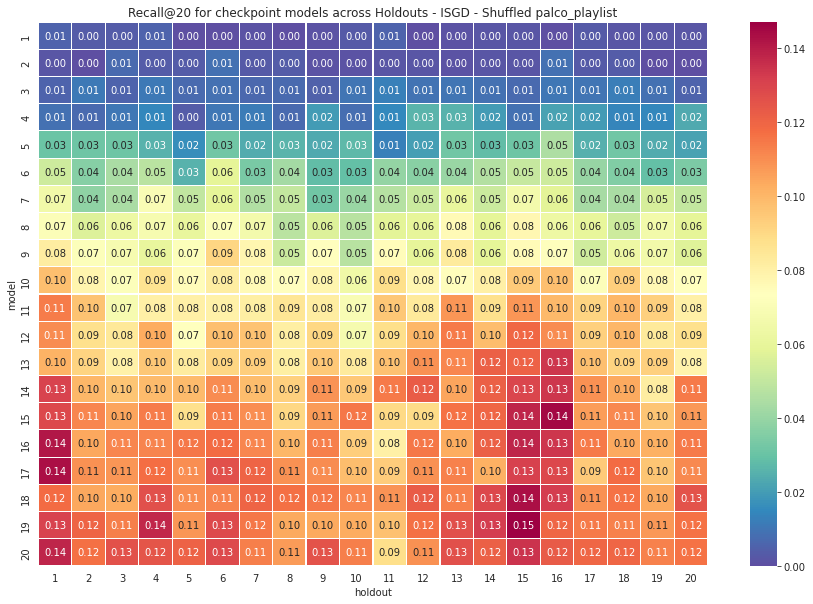

In [ ]:
plt.figure(figsize=(15, 10))
x_t = np.arange(0,20)
labels=[str(i+1) for i in x_t]
sns.heatmap(rm1.T, vmin=0, vmax=rm1.max().max(), annot=True, fmt='0.2f', linewidths=.1, cmap='Spectral_r', xticklabels=labels, yticklabels=labels)
plt.ylabel('model')
plt.xlabel('holdout')
plt.title('Recall@20 for checkpoint models across Holdouts - ISGD - Shuffled palco_2010');
plt.savefig('output/recall20 heatmap shuffled palco_2010');